In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Set the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load images
image1 = cv2.imread('/content/set11.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set12.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt1.tif', cv2.IMREAD_GRAYSCALE)

# Check if the images are loaded properly
if image1 is None or image2 is None or ground_truth is None:
    raise ValueError("One or more images could not be loaded. Please check the file paths.")

# Pad width
pad_width = 2

# Pad images
image1_padded = np.pad(image1, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')
image2_padded = np.pad(image2, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1].reshape(5, 5, 1)  # Reshape to 5x5x1 for CNN input

# Prepare data
data = []
labels = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data.append(np.dstack((neighbourhood1, neighbourhood2)))  # Stack the two neighborhoods to create a 5x5x2 input

# Convert data to a numpy array
data = np.array(data)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.array(change_samples + unchanged_samples)
y = np.array(change_labels + unchanged_labels)

# Reshape y to be a 1D array (for binary classification)
y = y.reshape(-1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the U-Net model for binary classification
def unet_model(input_shape=(5, 5, 2)):
    inputs = Input(input_shape)

    # Contracting path (Encoder)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((1, 1))(conv1) # Changed pool size to (1, 1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((1, 1))(conv2) # Changed pool size to (1, 1)


    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    # Removed MaxPooling layer

    # Bottleneck
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) # Changed input to conv3
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    # Expanding path (Decoder)
    # Removed upsampling & changed input to conv4
    up5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    concat5 = Concatenate()([up5, conv3])  # Ensure shapes are compatible
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    # Removed upsampling & changed input to conv5
    up6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    concat6 = Concatenate()([up6, conv2])  # Ensure shapes are compatible
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    # Removed upsampling & changed input to conv6
    up7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    concat7 = Concatenate()([up7, conv1])  # Ensure shapes are compatible
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    output = tf.keras.layers.Flatten()(conv7) # Flatten the output from the previous layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output) # Add a Dense layer with a single output and sigmoid activation

    # Create the model
    model = Model(inputs, output)
    return model
# Create the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Calculate N0 and N1
N0 = TP + FN  # Total number of changed pixels
N1 = TN + FP  # Total number of unchanged pixels

# Calculate metrics
PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
PFA = FP / N1 if N1 != 0 else 0
PTE = (FP + FN) / (N0 + N1) if (N0 + N1) != 0 else 0

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print the results
print(f"Model accuracy on test set: {accuracy:.2f}")
print(f"Correct Classification (CC): {TP + TN}")
print(f"False Alarms (FA): {FP}")
print(f"Total Error (TE): {FP + FN}")
print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
print(f"Probability of False Alarm (PFA): {PFA:.2f}")
print(f"Probability of Total Error (PTE): {PTE:.2f}")


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.5255 - loss: 1.6422 - val_accuracy: 0.8444 - val_loss: 0.4758
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.7683 - loss: 0.4655 - val_accuracy: 0.8556 - val_loss: 0.3832
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8402 - loss: 0.3816 - val_accuracy: 0.8667 - val_loss: 0.3583
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.8822 - loss: 0.3340 - val_accuracy: 0.8667 - val_loss: 0.3113
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9089 - loss: 0.2747 - val_accuracy: 0.8889 - val_loss: 0.2769
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9373 - loss: 0.2257 - val_accuracy: 0.8667 - val_loss: 0.2642
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9027 - loss: 0.2068 - val_accuracy: 0.8667 - val_loss: 0.2523
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.9394 - loss: 0.1665 - val_accuracy: 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


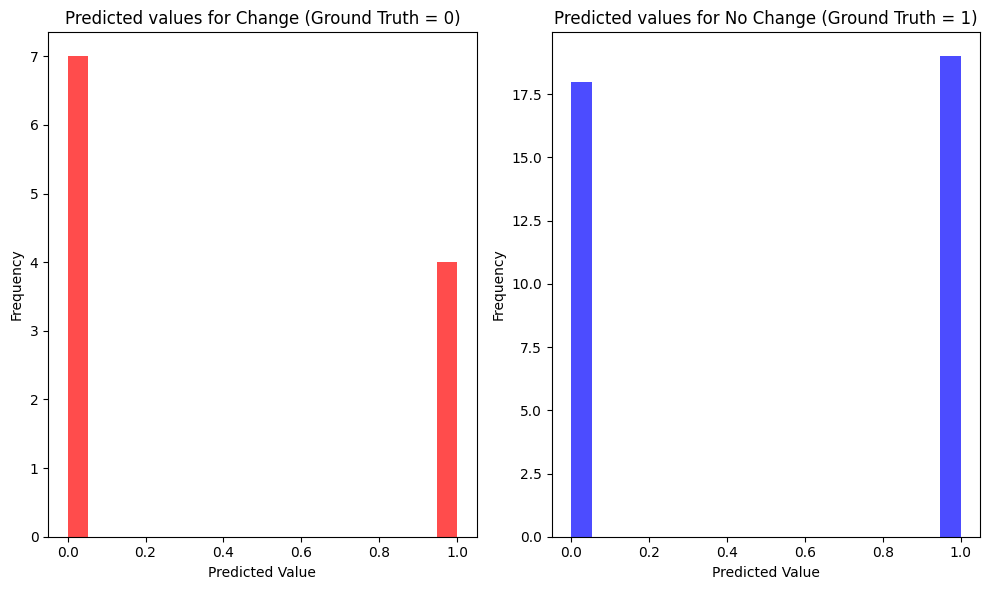

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the ground truth and predicted values (for this example, we're assuming you have the predictions from your trained model)
# Make sure you load the ground truth and predicted values as required
ground_truth = cv2.imread('/content/gt1.tif', cv2.IMREAD_GRAYSCALE)
y_pred = model.predict(X_test)  # Assuming you've trained your model and have predictions from the test set
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Get the indices where ground truth is 0 (change) and 1 (no change)
# Use ground_truth corresponding to the test set
ground_truth_test = ground_truth.flatten()[np.argwhere(y_test.flatten() == 0)]
#ground_truth_test = ground_truth.flatten()[np.argwhere(y_test.flatten() == 1)]

change_indices = np.where(ground_truth_test == 0)[0]  # Ground truth is 0 (change)
unchanged_indices = np.where(ground_truth_test == 255)[0]  # Ground truth is 1 (no change)

# Extract the predicted values for the change (0) and unchanged (1) locations
pred_change = y_pred_classes[change_indices]
pred_unchanged = y_pred_classes[unchanged_indices]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot predicted values for 'change' (ground truth = 0)
plt.subplot(1, 2, 1)
plt.hist(pred_change, bins=np.linspace(0, 1, 20), color='red', alpha=0.7)
plt.title("Predicted values for Change (Ground Truth = 0)")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")

# Plot predicted values for 'no change' (ground truth = 1)
plt.subplot(1, 2, 2)
plt.hist(pred_unchanged, bins=np.linspace(0, 1, 20), color='blue', alpha=0.7)
plt.title("Predicted values for No Change (Ground Truth = 1)")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
